In [1]:
import numpy as np
import matplotlib as mpl
%matplotlib inline

import pandas as pd

import json
import glob
import os

In [2]:
data = {}

for path in glob.glob(os.path.expanduser("/amd.home/home/i11/zeitz/ma/data/results/paper/weak_scaling/*.json")):
  for typename, items in json.load(open(path)).items():
    if typename in data:
      data[typename].update(items)
    else:
      data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [3]:
algo_name_mapping = {
    'synchronous local moving with map equation': 'Distr. MapEq',
    'synchronous local moving with modularity': 'Distr. Modularity'
}

frames['algorithm_run'].replace({ 'algorithm': algo_name_mapping }, inplace=True)

frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['switch_to_seq'].map({ False: '', True: ' w. Seq.', np.NaN: '' })

In [4]:
frames['algorithm_run']['runtime'] = (frames['algorithm_run']['done_ts'] - frames['algorithm_run']['start_ts']) / 1000000.0
distributed_algo_runs = frames['algorithm_run'][pd.isnull(frames['algorithm_run'].distributed_algorithm_run_id)]

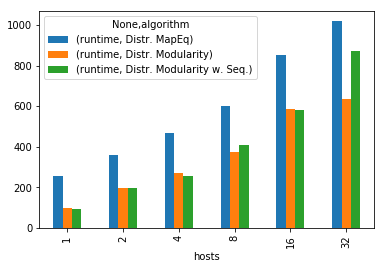

In [5]:
distributed_algo_runs \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['hosts', 'algorithm'])['runtime'].mean().to_frame().unstack().plot.bar()

In [8]:
frames['algorithm_level'] \
    .loc[lambda x: x['level'] == 0] \
    .merge(distributed_algo_runs, left_on='algorithm_run_id', right_index=True)

,iterations,algorithm_run_id,node_count,cluster_count,level,start_ts,done_ts,program_run_id,algorithm,distributed_algorithm_run_id,runtime
1e7ba748-4965-4a89-b5e8-4da98482ae52,11.0,156a52a7-3e88-4396-a132-aee6e19bcc35,32000000,14760,0,1.506071e+15,1.506071e+15,9e33d45e-6710-495b-be3f-4d3d2ac212ce,Distr. Modularity w. Seq.,NaN,407.316585
29a6922f-44c9-4a8d-9e2e-90904cff4744,11.0,aae261fa-a207-4cfb-a268-2e65e7dddc91,8000000,3806,0,1.506070e+15,1.506070e+15,05d04da7-617c-4113-8b55-0ab8b03d1e4b,Distr. Modularity w. Seq.,NaN,195.378888
320d9826-6230-4755-94ee-febb47a87b27,11.0,8b3c8efc-753b-4ba2-8c42-5fc8d4b03432,4000000,1879,0,1.506071e+15,1.506071e+15,c844cf29-a61e-4bfa-a003-4e7bc87860bd,Distr. Modularity w. Seq.,NaN,95.954758
34a01443-06be-4c2e-9005-c4c6ef3dab8f,11.0,e79de921-e7d7-492e-aff9-d4d3bd53e8e7,16000000,7452,0,1.506071e+15,1.506071e+15,fe778045-769c-4bea-bf54-cea316628adb,Distr. Modularity,NaN,269.575045
3918ac60-8deb-43c4-b0a4-f557b89c0256,15.0,0f00307e-fda4-4d90-9528-a9801ff02e1c,32000000,14752,0,1.506071e+15,1.506071e+15,a89810bd-4967-40d3-91bd-8e4a131206e0,Distr. MapEq,NaN,599.525869
3cea6caa-c3b4-450b-b216-3a4a93b4f731,11.0,3e3561e4-1946-48c8-83b4-86bae0728e6d,4000000,1878,0,1.506071e+15,1.506071e+15,5992c9b0-846d-4e20-ae06-56c974f40264,Distr. Modularity,NaN,98.321682
4e77f68c-470d-4b82-86ac-57f5eb7cf3df,11.0,c0b5ee94-a915-4225-bed4-304046c52878,64000000,29619,0,1.506072e+15,1.506072e+15,a507cfe4-7c21-4873-8d69-e0504562d022,Distr. Modularity,NaN,586.070343
5f7a471e-e382-4fc5-8595-bbc4de3bf60e,15.0,a0a29ee1-792f-4a7f-ad59-b99d696447c3,16000000,7440,0,1.506071e+15,1.506071e+15,79ce1da5-349f-4cc5-9c9e-0b4f730adc7f,Distr. MapEq,NaN,468.973677
67a529c9-9634-42cf-a766-65ef8910e965,11.0,845c34a5-aad7-43e0-97df-2146e0154709,32000000,14740,0,1.506071e+15,1.506071e+15,ff0a90c6-97b3-42ff-8f6d-eed374c5bc35,Distr. Modularity,NaN,373.393830
692ade61-5e14-4bd6-a5c2-7769d4fedb56,15.0,02aba055-3cd4-463c-b4e8-a204b0f9b807,4000000,1894,0,1.506071e+15,1.506071e+15,5ad82cdf-28f3-4779-a9f3-7673ca88a1aa,Distr. MapEq,NaN,254.111319
